In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
# Load the cleaned dataset
df = pd.read_csv('C:/Users/cyyyyyy/Desktop/output_dataset.csv')
df.info()

df['Result'] = df['Result'].replace({1: 1, 2: 0})

# Prepare data for modeling
X = df[['Total Bilirubin', 'Alkphos Alkaline Phosphotase',
        'Sgpt Alamine Aminotransferase', 'Sgot Aspartate Aminotransferase',
        'Total Protiens', 'ALB Albumin', 'A/G Ratio Albumin and Globulin Ratio',
        'Bilirubin Ratio', 'SGOT/SGPT Ratio', 'Protien Ratio']]

y = df['Result']

# Split data into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30691 entries, 0 to 30690
Data columns (total 16 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Age                                   30689 non-null  float64
 1   Gender                                30691 non-null  float64
 2   Total Bilirubin                       30691 non-null  float64
 3   Alkphos Alkaline Phosphotase          30691 non-null  float64
 4   Sgpt Alamine Aminotransferase         30691 non-null  float64
 5   Sgot Aspartate Aminotransferase       30691 non-null  float64
 6   Total Protiens                        30691 non-null  float64
 7   ALB Albumin                           30691 non-null  float64
 8   A/G Ratio Albumin and Globulin Ratio  30691 non-null  float64
 9   Result                                30691 non-null  int64  
 10  Bilirubin Ratio                       30691 non-null  float64
 11  SGOT/SGPT Ratio

In [19]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.9912037791171201
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98      1755
           1       0.99      0.99      0.99      4384

    accuracy                           0.99      6139
   macro avg       0.99      0.99      0.99      6139
weighted avg       0.99      0.99      0.99      6139

Confusion Matrix:
 [[1725   30]
 [  24 4360]]


In [21]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_neighbors': [3,5,7,9,11,13,15,17,19,21,23,25],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski','cosine']
}

grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best accuracy:", grid.best_score_)


Best parameters: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}
Best accuracy: 0.9964565352894557


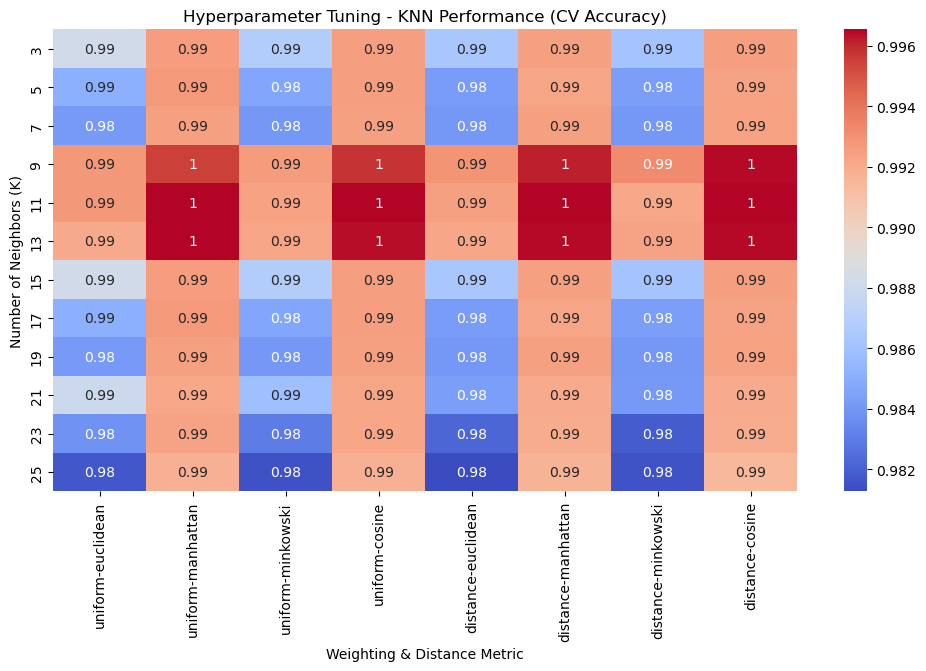

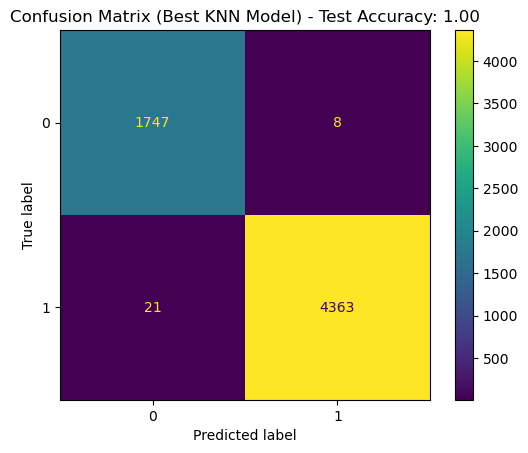

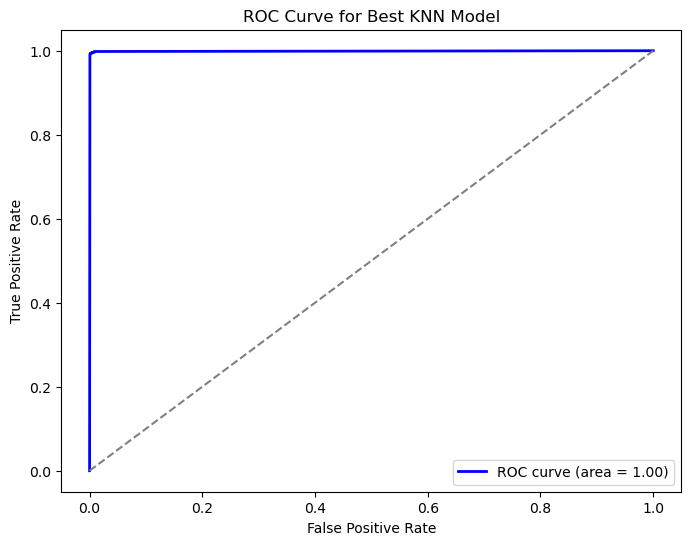

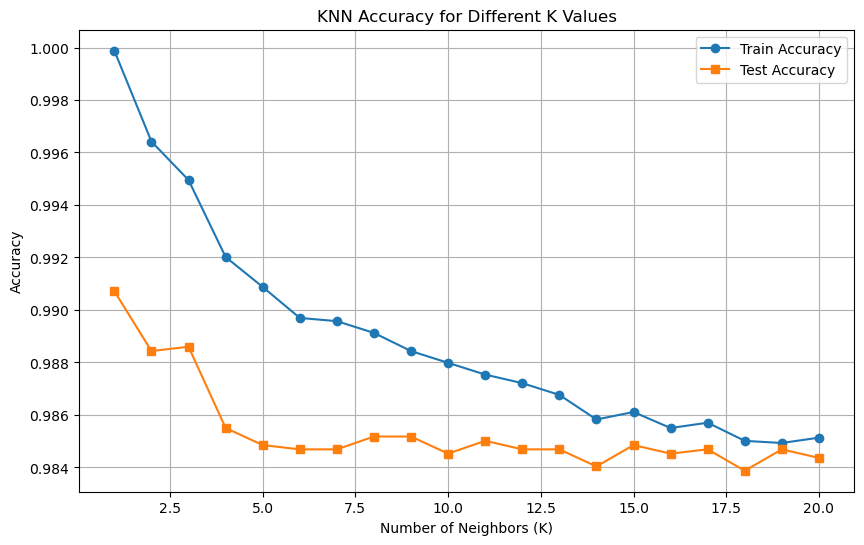

Best Parameters: {'metric': 'manhattan', 'n_neighbors': 17, 'weights': 'distance'}
Best Cross-Validation Accuracy: 0.9965379933902903

Classification Report on Test Data:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      1755
           1       1.00      1.00      1.00      4384

    accuracy                           1.00      6139
   macro avg       0.99      1.00      0.99      6139
weighted avg       1.00      1.00      1.00      6139



In [37]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

param_grid = {
    'n_neighbors': [3,5,7,9,11,13,15,17,19,21,23,25],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski','cosine']
}

grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
grid.fit(X_train_scaled, y_train)
best_params = grid.best_params_
best_score = grid.best_score_

best_knn = KNeighborsClassifier(**best_params)
best_knn.fit(X_train_scaled, y_train)

y_pred_best = best_knn.predict(X_test_scaled)

y_pred_proba = best_knn.predict_proba(X_test_scaled)[:, 1]  # 获取正类的概率

test_accuracy = accuracy_score(y_test, y_pred_best)

results = grid.cv_results_
scores_matrix = np.array(results["mean_test_score"]).reshape(len(param_grid['n_neighbors']), len(param_grid['weights']) * len(param_grid['metric']))

plt.figure(figsize=(12, 6))
sns.heatmap(scores_matrix, annot=True, cmap="coolwarm", 
            xticklabels=[f"{w}-{m}" for w in param_grid['weights'] for m in param_grid['metric']],
            yticklabels=param_grid['n_neighbors'])
plt.xlabel("Weighting & Distance Metric")
plt.ylabel("Number of Neighbors (K)")
plt.title("Hyperparameter Tuning - KNN Performance (CV Accuracy)")
plt.show()

# 绘制最佳模型的混淆矩阵
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_knn.classes_)
disp.plot()
plt.title(f'Confusion Matrix (Best KNN Model) - Test Accuracy: {test_accuracy:.2f}')
plt.show()

# 绘制ROC曲线
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Best KNN Model")
plt.legend(loc="lower right")
plt.show()

# 绘制不同K值的准确率变化曲线
k_values = list(range(1, 25))
train_accuracies = []
test_accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    train_accuracies.append(knn.score(X_train_scaled, y_train))
    test_accuracies.append(knn.score(X_test_scaled, y_test))

plt.figure(figsize=(10,6))
plt.plot(k_values, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(k_values, test_accuracies, label='Test Accuracy', marker='s')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Accuracy')
plt.title('KNN Accuracy for Different K Values')
plt.legend()
plt.grid()
plt.show()

print("Best Parameters:", best_params)
print("Best Cross-Validation Accuracy:", best_score)
print("\nClassification Report on Test Data:\n", classification_report(y_test, y_pred_best))



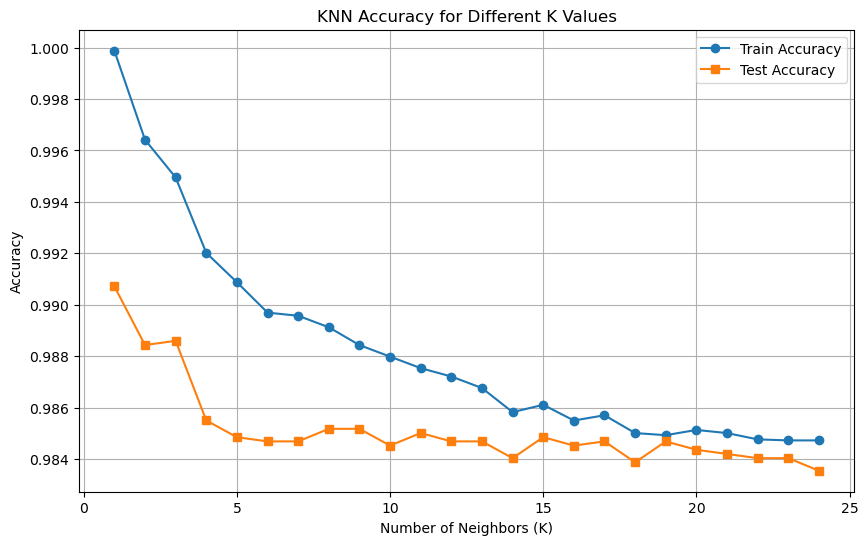

Best Parameters: {'metric': 'manhattan', 'n_neighbors': 17, 'weights': 'distance'}
Best Cross-Validation Accuracy: 0.9965379933902903

Classification Report on Test Data:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      1755
           1       1.00      1.00      1.00      4384

    accuracy                           1.00      6139
   macro avg       0.99      1.00      0.99      6139
weighted avg       1.00      1.00      1.00      6139



In [39]:
k_values = list(range(1, 25))
train_accuracies = []
test_accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    train_accuracies.append(knn.score(X_train_scaled, y_train))
    test_accuracies.append(knn.score(X_test_scaled, y_test))

plt.figure(figsize=(10,6))
plt.plot(k_values, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(k_values, test_accuracies, label='Test Accuracy', marker='s')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Accuracy')
plt.title('KNN Accuracy for Different K Values')
plt.legend()
plt.grid()
plt.show()

print("Best Parameters:", best_params)
print("Best Cross-Validation Accuracy:", best_score)
print("\nClassification Report on Test Data:\n", classification_report(y_test, y_pred_best))

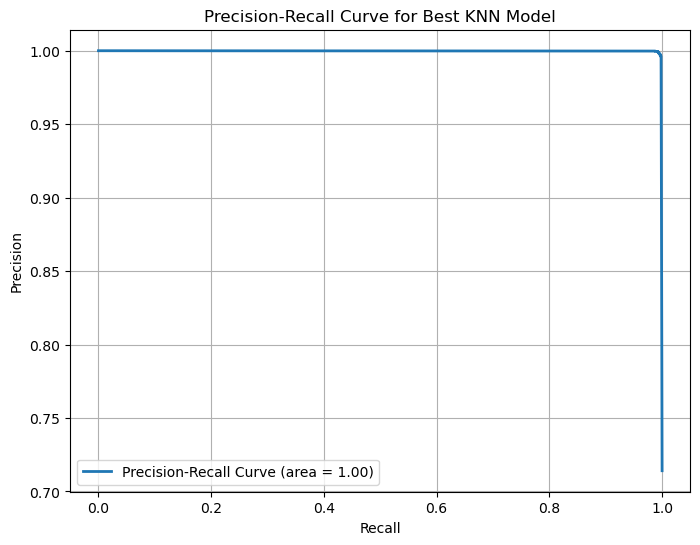

In [29]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8,6))
plt.plot(recall, precision, lw=2, label=f'Precision-Recall Curve (area = {roc_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Best KNN Model')
plt.legend(loc="lower left")
plt.grid()
plt.show()

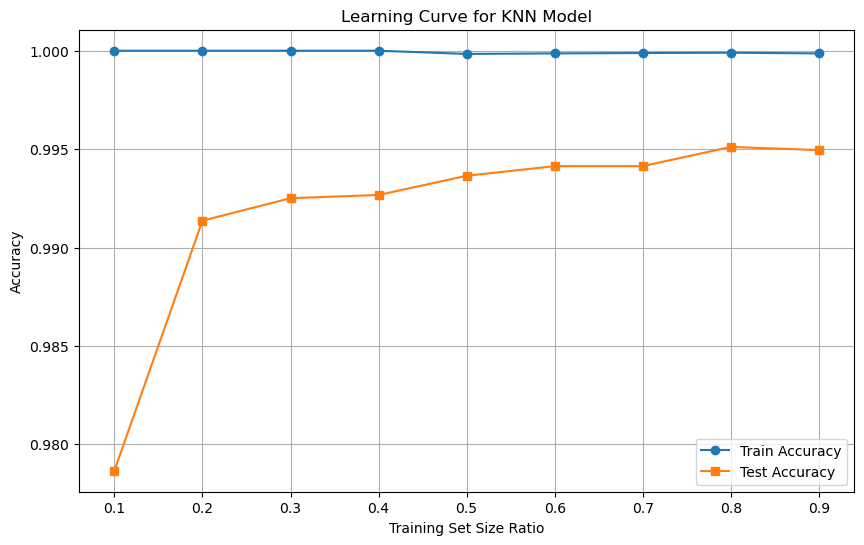

In [33]:
train_sizes = np.linspace(0.1, 0.9, 9)  # 调整最大值为0.9，而不是1.0

train_accuracies = []
test_accuracies = []

for size in train_sizes:
    X_partial, _, y_partial, _ = train_test_split(X_train_scaled, y_train, train_size=size, random_state=42)
    knn = KNeighborsClassifier(**best_params)
    knn.fit(X_partial, y_partial)
    train_accuracy = knn.score(X_partial, y_partial)
    test_accuracy = knn.score(X_test_scaled, y_test)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_accuracies, marker='o', label='Train Accuracy')
plt.plot(train_sizes, test_accuracies, marker='s', label='Test Accuracy')
plt.xlabel('Training Set Size Ratio')
plt.ylabel('Accuracy')
plt.title('Learning Curve for KNN Model')
plt.legend()
plt.grid()
plt.show()




In [35]:
print(y_train.value_counts())
print(y_test.value_counts())


Result
1    17533
0     7019
Name: count, dtype: int64
Result
1    4384
0    1755
Name: count, dtype: int64
